In [55]:
# Machine-Learning-Spectrogram-CNN-Project

# For this project, the free-spoken-digit-dataset was used.

# I do not own the rights to this dataset.
# This was obtained from a free open source community and can
# be found at the following sources:

# GitHub: Jakobovski
# https://github.com/Jakobovski/free-spoken-digit-dataset

# Kaggle: Jose R. Zapata
# https://www.kaggle.com/datasets/joserzapata/free-spoken-digit-dataset-fsdd

%reset
import os, wave, pylab, shutil, time
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from pathlib import Path
from tqdm import tqdm

Nothing done.


In [56]:
input_folder = './free-spoken-digit-dataset/recordings/'
output_folder = './free-spoken-digit-dataset/working/'
figsize = (12, 12)

data_folder = os.listdir(input_folder)
for i in range(10):
    print(data_folder[i])

0_george_0.wav
0_george_1.wav
0_george_10.wav
0_george_11.wav
0_george_12.wav
0_george_13.wav
0_george_14.wav
0_george_15.wav
0_george_16.wav
0_george_17.wav


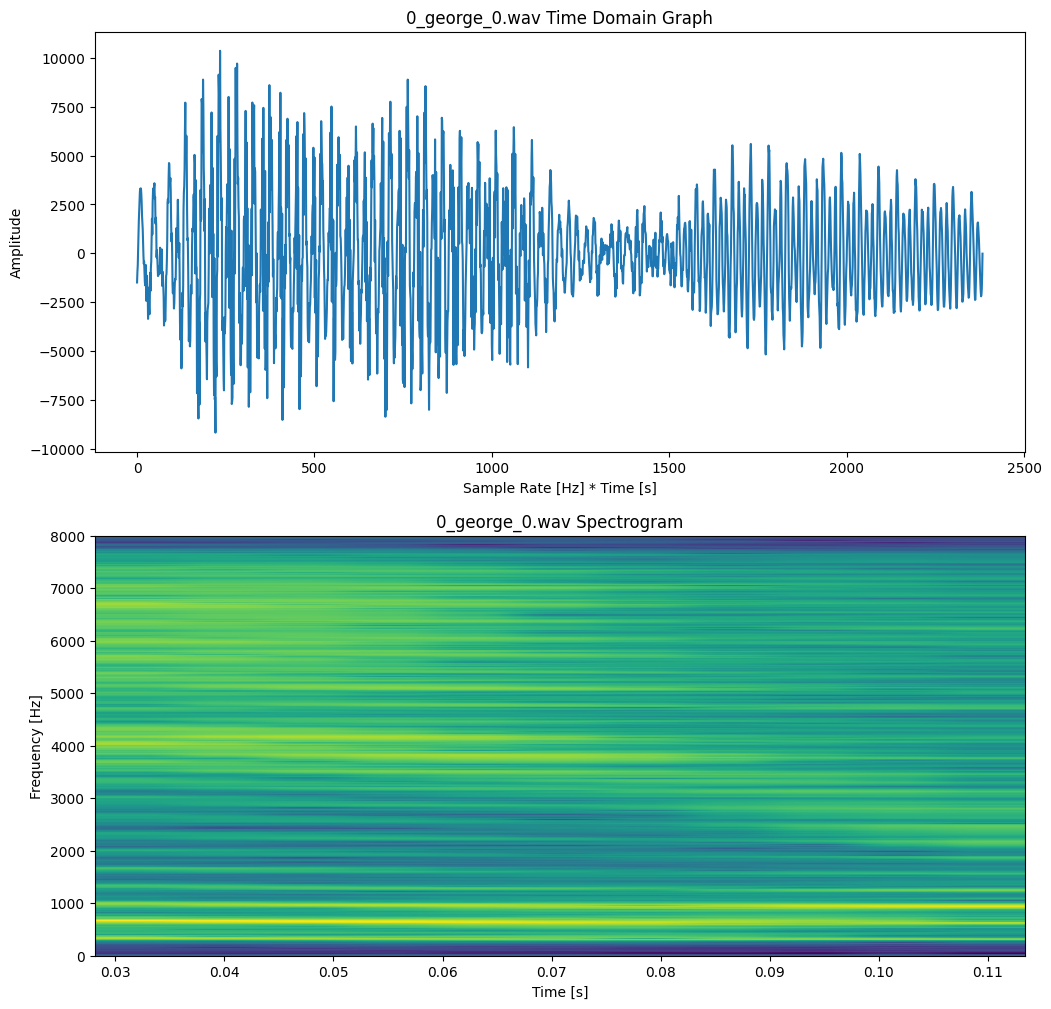

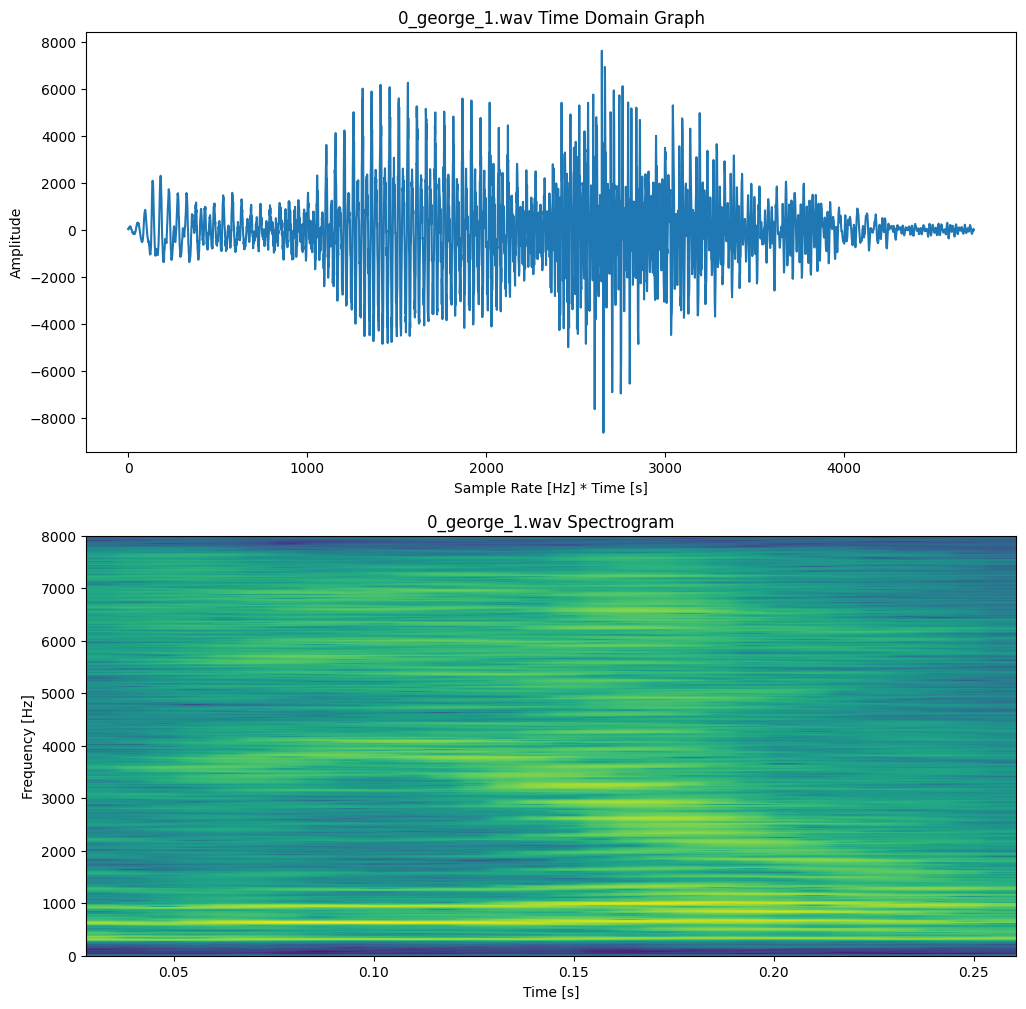

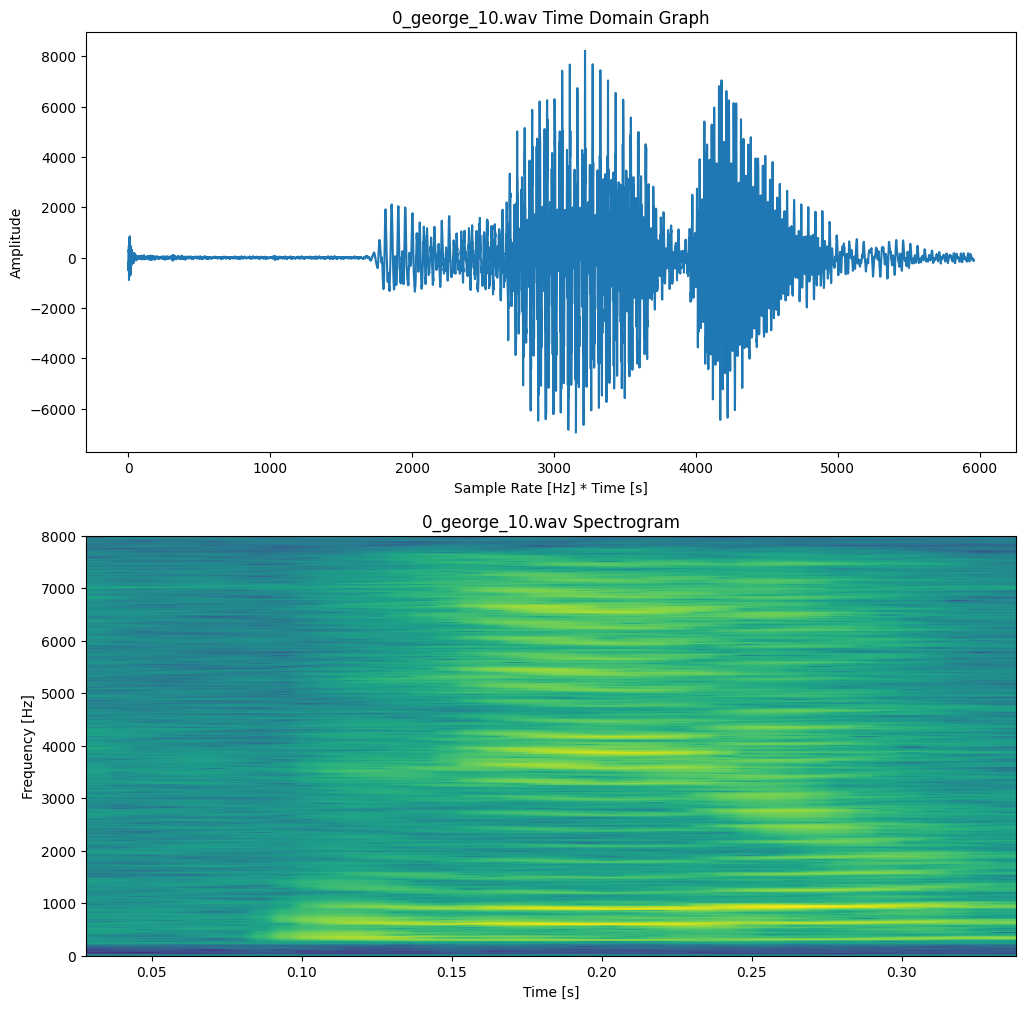

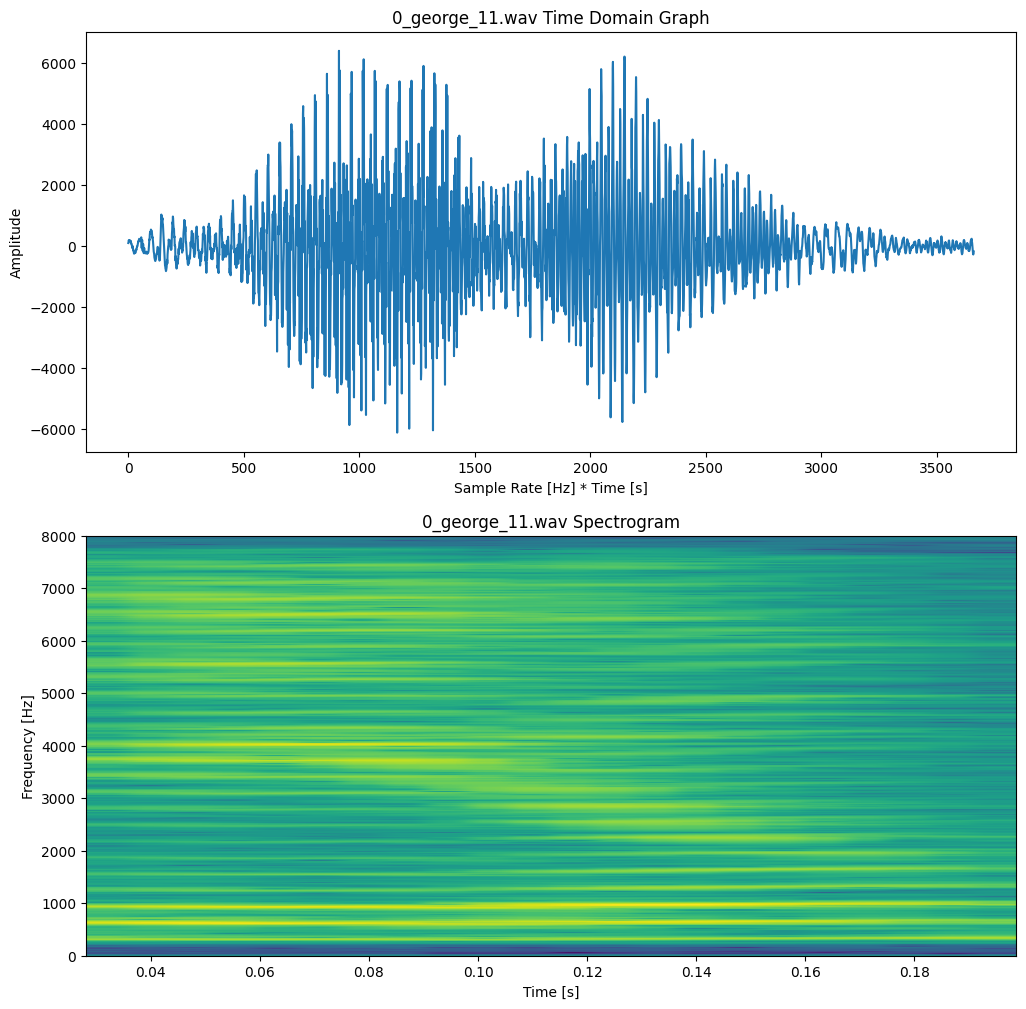

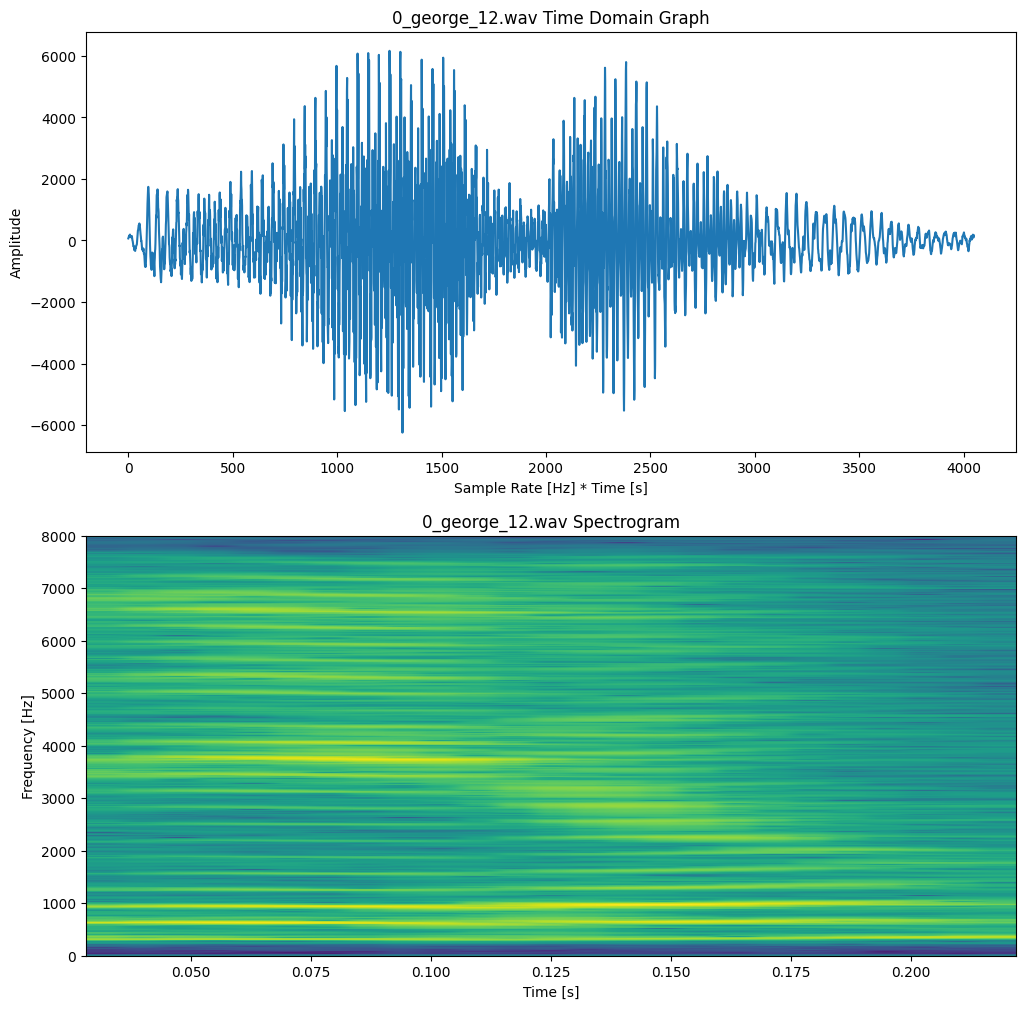

In [57]:
for i in range(5):
    wav_file = wave.open(os.path.join(input_folder, data_folder[i]), 'r')
    sr = 16000
    sign = np.frombuffer(wav_file.readframes(sr), dtype=np.int16)
    plt.figure(figsize=figsize)
    plt.subplot(2, 1, 1)
    plt.plot(sign)
    plt.title(data_folder[i] + ' Time Domain Graph')
    plt.xlabel('Sample Rate [Hz] * Time [s]')
    plt.ylabel('Amplitude')
    
    plt.subplot(2, 1, 2)
    plt.specgram(sign, NFFT=1024, Fs=sr, noverlap=900)
    plt.title(data_folder[i] + ' Spectrogram')
    plt.xlabel('Time [s]')
    plt.ylabel('Frequency [Hz]')

In [58]:
def get_signal_details(wav_file):
    sign = wave.open(wav_file, 'r')
    fr = sign.readframes(-1)
    ampl = pylab.frombuffer(fr, 'int16')
    fr_rate = sign.getframerate()
    sign.close()
    return ampl, fr_rate

if not os.path.exists(os.path.join(output_folder, 'audio-images')):
    os.mkdir(os.path.join(output_folder, 'audio-images'))

for file in tqdm(os.listdir(input_folder)):
    if 'wav' in file:
        file_path = os.path.join(input_folder, file)
        file_stem = Path(file_path).stem
        file_dir = f'class_{file_stem[0]}'
        out_dir = os.path.join(os.path.join(output_folder, 'audio-images'), file_dir)
        out_path = os.path.join(out_dir, file_stem)
        if not os.path.exists(out_path + '.png'):
            if not os.path.exists(out_dir):
                os.mkdir(out_dir)
            file_stem = Path(file_path).stem
            ampl, fr_rate = get_signal_details(file_path)
            pylab.specgram(ampl, Fs=fr_rate)
            pylab.savefig(f'{out_path}.png')
            pylab.close()

folder_list = os.listdir(os.path.join(output_folder, 'audio-images'))
print('Classes: \n')
for i in range(10):
    print(folder_list[i])

folder_list = os.listdir(os.path.join(output_folder, 'audio-images/class_1'))
print('\nA few example files:\n')
for i in range(10):
    print(folder_list[i])

100%|██████████| 3000/3000 [00:00<00:00, 22053.85it/s]

Classes: 

class_0
class_1
class_2
class_3
class_4
class_5
class_6
class_7
class_8
class_9

A few example files:

1_george_0.png
1_george_1.png
1_george_10.png
1_george_11.png
1_george_12.png
1_george_13.png
1_george_14.png
1_george_15.png
1_george_16.png
1_george_17.png


Found 3000 files belonging to 10 classes.
Using 2400 files for training.
Using 600 files for validation.


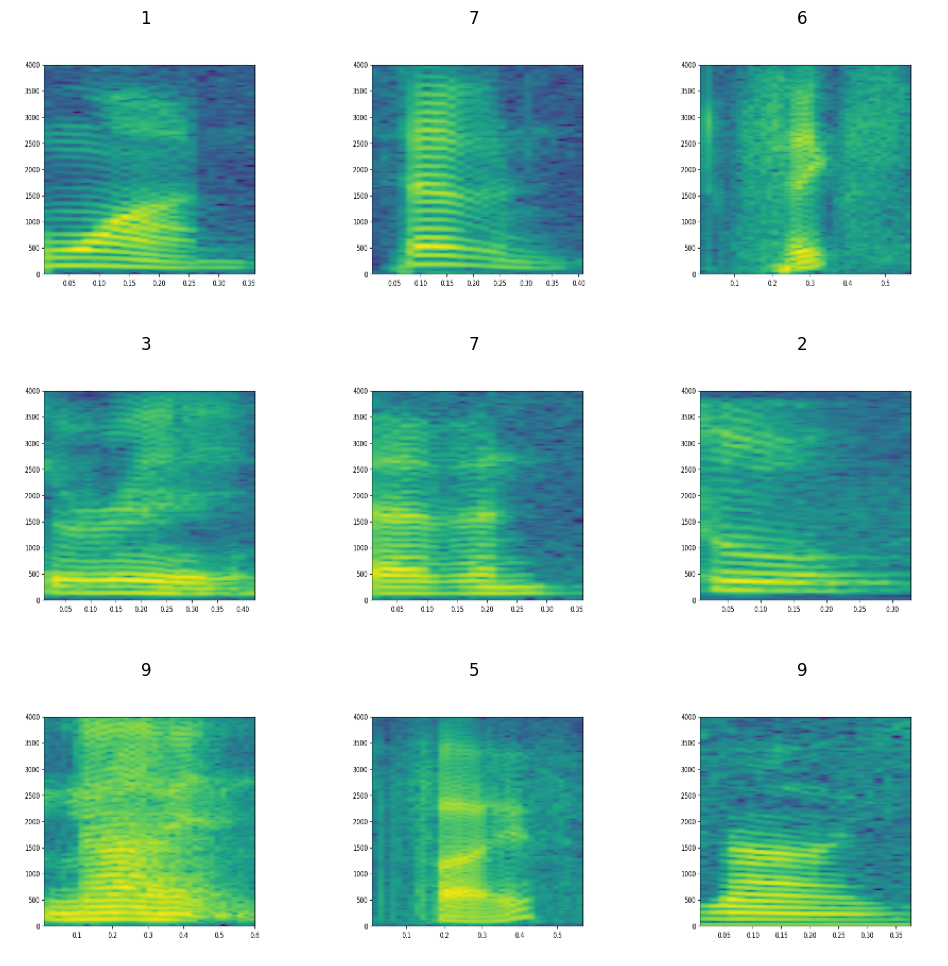

In [59]:
img_width = 256
img_height = 256
batch_size = 32
n_channels = 3
n_classes = 10

train_set, validation_set = tf.keras.preprocessing.image_dataset_from_directory(batch_size=batch_size, validation_split=0.2,
    directory=os.path.join(output_folder, 'audio-images'), shuffle=True, color_mode='rgb',
    image_size=(img_height, img_width), subset='both', seed=0)

plt.figure(figsize=figsize)
for img, labels in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title(int(labels[i]))
        plt.axis('off')
plt.show()

In [60]:
def preproc(dataset, augment=False):
    rescale = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1./255)])
    flip_rot = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)])
    dataset = dataset.map(map_func=lambda x, y: (rescale(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    if augment: dataset = dataset.map(map_func=lambda x, y: (flip_rot(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

train_set = preproc(train_set, augment=False)
validation_set = preproc(validation_set, augment=False)

In [61]:
def build_new_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=(img_height, img_width, n_channels)))
    model.add(tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(n_classes, activation='softmax'))
    return model

In [62]:
def compile_train_eval_time(optPhrase, model, timeList, perfList):
    if optPhrase == 'Adadelta':
        model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adadelta(), metrics=['accuracy'])
    elif optPhrase == 'Adagrad':
        model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adagrad(), metrics=['accuracy'])
    elif optPhrase == 'Adam':
        model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
    elif optPhrase == 'Adamax':
        model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adamax(), metrics=['accuracy'])
    elif optPhrase == 'Ftrl':
        model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Ftrl(), metrics=['accuracy'])
    elif optPhrase == 'Nadam':
        model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Nadam(), metrics=['accuracy'])
    elif optPhrase == 'RMSprop':
        model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(), metrics=['accuracy'])
    elif optPhrase == 'SGD':
        model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(), metrics=['accuracy'])
    
    start = time.time()
    history = model.fit(train_set, epochs=50, validation_data=validation_set)
    end = time.time()    
    temp = round((end - start), 2)
    mins = int(np.floor(temp/60))
    secs = round((temp/60 - mins)*60, 2)
    timeList.at['Train', optPhrase] = '{}m {}s'.format(mins, secs)

    start = time.time()
    eval_loss, eval_accur = model.evaluate(validation_set, verbose=0)
    end = time.time()
    temp = round((end - start), 2)
    mins = int(np.floor(temp/60))
    secs = round((temp/60 - mins)*60, 2)
    timeList.at['Test', optPhrase] = '{}m {}s'.format(mins, secs)
    
    perfList.at['Loss', optPhrase] = round(eval_loss, 4)
    perfList.at['Accuracy', optPhrase] = round(eval_accur, 4)
    return history, timeList, perfList

In [63]:
timeList = pd.DataFrame(columns=['Adadelta', 'Adagrad', 'Adam', 'Adamax', 'Ftrl', 'Nadam', 'RMSprop', 'SGD'], index=['Train', 'Test'])
perfList = pd.DataFrame(columns=['Adadelta', 'Adagrad', 'Adam', 'Adamax', 'Ftrl', 'Nadam', 'RMSprop', 'SGD'], index=['Loss', 'Accuracy'])
adad_model = build_new_model()
adad_history, timeList, perfList = compile_train_eval_time('Adadelta', adad_model, timeList, perfList)

Epoch 1/50
75/75 [==============================] - 5s 60ms/step - loss: 3.0986 - accuracy: 0.1300 - val_loss: 2.5885 - val_accuracy: 0.1133
Epoch 2/50
75/75 [==============================] - 4s 57ms/step - loss: 2.5844 - accuracy: 0.2121 - val_loss: 2.9581 - val_accuracy: 0.1133
Epoch 3/50
75/75 [==============================] - 4s 56ms/step - loss: 2.2357 - accuracy: 0.2871 - val_loss: 3.0844 - val_accuracy: 0.1133
Epoch 4/50
75/75 [==============================] - 4s 56ms/step - loss: 1.9599 - accuracy: 0.3592 - val_loss: 3.0784 - val_accuracy: 0.1283
Epoch 5/50
75/75 [==============================] - 4s 55ms/step - loss: 1.7507 - accuracy: 0.4133 - val_loss: 2.8264 - val_accuracy: 0.1617
Epoch 6/50
75/75 [==============================] - 4s 56ms/step - loss: 1.6586 - accuracy: 0.4475 - val_loss: 2.7799 - val_accuracy: 0.1800
Epoch 7/50
75/75 [==============================] - 4s 55ms/step - loss: 1.5265 - accuracy: 0.4946 - val_loss: 2.5938 - val_accuracy: 0.2183
Epoch 8/50
75

In [64]:
adag_model = build_new_model()
adag_history, timeList, perfList = compile_train_eval_time('Adagrad', adag_model, timeList, perfList)

Epoch 1/50
75/75 [==============================] - 5s 58ms/step - loss: 0.9120 - accuracy: 0.7075 - val_loss: 3.1082 - val_accuracy: 0.0867
Epoch 2/50
75/75 [==============================] - 4s 55ms/step - loss: 0.3271 - accuracy: 0.9013 - val_loss: 3.6537 - val_accuracy: 0.0867
Epoch 3/50
75/75 [==============================] - 4s 54ms/step - loss: 0.2123 - accuracy: 0.9446 - val_loss: 4.0272 - val_accuracy: 0.1617
Epoch 4/50
75/75 [==============================] - 4s 54ms/step - loss: 0.1755 - accuracy: 0.9538 - val_loss: 4.1674 - val_accuracy: 0.1467
Epoch 5/50
75/75 [==============================] - 4s 53ms/step - loss: 0.1268 - accuracy: 0.9721 - val_loss: 3.7802 - val_accuracy: 0.2950
Epoch 6/50
75/75 [==============================] - 4s 54ms/step - loss: 0.1013 - accuracy: 0.9783 - val_loss: 2.9686 - val_accuracy: 0.3417
Epoch 7/50
75/75 [==============================] - 4s 54ms/step - loss: 0.0870 - accuracy: 0.9846 - val_loss: 1.7766 - val_accuracy: 0.5183
Epoch 8/50
75

In [65]:
adam_model = build_new_model()
adam_history, timeList, perfList = compile_train_eval_time('Adam', adam_model, timeList, perfList)

Epoch 1/50
75/75 [==============================] - 5s 59ms/step - loss: 0.6983 - accuracy: 0.7837 - val_loss: 7.3748 - val_accuracy: 0.1150
Epoch 2/50
75/75 [==============================] - 4s 56ms/step - loss: 0.2013 - accuracy: 0.9433 - val_loss: 8.9907 - val_accuracy: 0.1150
Epoch 3/50
75/75 [==============================] - 4s 56ms/step - loss: 0.0926 - accuracy: 0.9754 - val_loss: 9.3052 - val_accuracy: 0.1150
Epoch 4/50
75/75 [==============================] - 4s 55ms/step - loss: 0.0639 - accuracy: 0.9837 - val_loss: 8.9124 - val_accuracy: 0.1150
Epoch 5/50
75/75 [==============================] - 4s 56ms/step - loss: 0.0382 - accuracy: 0.9921 - val_loss: 6.5459 - val_accuracy: 0.1250
Epoch 6/50
75/75 [==============================] - 4s 56ms/step - loss: 0.0258 - accuracy: 0.9962 - val_loss: 4.0764 - val_accuracy: 0.2133
Epoch 7/50
75/75 [==============================] - 4s 55ms/step - loss: 0.0173 - accuracy: 0.9979 - val_loss: 1.6904 - val_accuracy: 0.5017
Epoch 8/50
75

In [66]:
adax_model = build_new_model()
adax_history, timeList, perfList = compile_train_eval_time('Adamax', adax_model, timeList, perfList)

Epoch 1/50
75/75 [==============================] - 5s 57ms/step - loss: 0.7467 - accuracy: 0.7708 - val_loss: 5.0379 - val_accuracy: 0.1150
Epoch 2/50
75/75 [==============================] - 4s 56ms/step - loss: 0.1933 - accuracy: 0.9508 - val_loss: 7.8276 - val_accuracy: 0.1150
Epoch 3/50
75/75 [==============================] - 4s 54ms/step - loss: 0.1067 - accuracy: 0.9746 - val_loss: 8.5998 - val_accuracy: 0.1150
Epoch 4/50
75/75 [==============================] - 4s 54ms/step - loss: 0.0640 - accuracy: 0.9887 - val_loss: 7.5441 - val_accuracy: 0.1150
Epoch 5/50
75/75 [==============================] - 4s 54ms/step - loss: 0.0420 - accuracy: 0.9950 - val_loss: 5.0108 - val_accuracy: 0.1150
Epoch 6/50
75/75 [==============================] - 4s 54ms/step - loss: 0.0268 - accuracy: 0.9975 - val_loss: 2.8617 - val_accuracy: 0.2400
Epoch 7/50
75/75 [==============================] - 4s 54ms/step - loss: 0.0194 - accuracy: 0.9996 - val_loss: 0.9152 - val_accuracy: 0.6433
Epoch 8/50
75

In [68]:
ftrl_model = build_new_model()
ftrl_history, timeList, perfList = compile_train_eval_time('Ftrl', ftrl_model, timeList, perfList)

Epoch 1/50
75/75 [==============================] - 6s 59ms/step - loss: 2.3093 - accuracy: 0.0942 - val_loss: 2.3026 - val_accuracy: 0.0867
Epoch 2/50
75/75 [==============================] - 5s 58ms/step - loss: 2.3026 - accuracy: 0.1000 - val_loss: 2.3027 - val_accuracy: 0.0867
Epoch 3/50
75/75 [==============================] - 4s 56ms/step - loss: 2.3026 - accuracy: 0.1033 - val_loss: 2.3027 - val_accuracy: 0.0867
Epoch 4/50
75/75 [==============================] - 4s 56ms/step - loss: 2.3026 - accuracy: 0.1033 - val_loss: 2.3027 - val_accuracy: 0.0867
Epoch 5/50
75/75 [==============================] - 4s 56ms/step - loss: 2.3026 - accuracy: 0.1033 - val_loss: 2.3027 - val_accuracy: 0.0867
Epoch 6/50
75/75 [==============================] - 4s 55ms/step - loss: 2.3026 - accuracy: 0.1033 - val_loss: 2.3027 - val_accuracy: 0.0867
Epoch 7/50
75/75 [==============================] - 4s 57ms/step - loss: 2.3026 - accuracy: 0.1033 - val_loss: 2.3028 - val_accuracy: 0.0867
Epoch 8/50
75

In [69]:
nadam_model = build_new_model()
nadam_history, timeList, perfList = compile_train_eval_time('Nadam', nadam_model, timeList, perfList)

Epoch 1/50
75/75 [==============================] - 7s 63ms/step - loss: 0.5938 - accuracy: 0.8192 - val_loss: 3.9811 - val_accuracy: 0.1217
Epoch 2/50
75/75 [==============================] - 5s 64ms/step - loss: 0.1219 - accuracy: 0.9683 - val_loss: 4.0194 - val_accuracy: 0.1617
Epoch 3/50
75/75 [==============================] - 5s 67ms/step - loss: 0.0734 - accuracy: 0.9837 - val_loss: 2.8112 - val_accuracy: 0.2517
Epoch 4/50
75/75 [==============================] - 5s 65ms/step - loss: 0.0556 - accuracy: 0.9896 - val_loss: 3.3626 - val_accuracy: 0.1450
Epoch 5/50
75/75 [==============================] - 5s 63ms/step - loss: 0.0391 - accuracy: 0.9933 - val_loss: 1.9483 - val_accuracy: 0.3933
Epoch 6/50
75/75 [==============================] - 5s 62ms/step - loss: 0.0197 - accuracy: 0.9975 - val_loss: 0.6288 - val_accuracy: 0.7850
Epoch 7/50
75/75 [==============================] - 5s 63ms/step - loss: 0.0109 - accuracy: 0.9996 - val_loss: 0.3028 - val_accuracy: 0.9200
Epoch 8/50
75

In [70]:
rms_model = build_new_model()
rms_history, timeList, perfList = compile_train_eval_time('RMSprop', rms_model, timeList, perfList)

Epoch 1/50
75/75 [==============================] - 6s 61ms/step - loss: 0.6997 - accuracy: 0.7971 - val_loss: 4.3875 - val_accuracy: 0.1150
Epoch 2/50
75/75 [==============================] - 5s 59ms/step - loss: 0.2251 - accuracy: 0.9433 - val_loss: 3.6443 - val_accuracy: 0.2017
Epoch 3/50
75/75 [==============================] - 5s 59ms/step - loss: 0.1443 - accuracy: 0.9704 - val_loss: 3.5827 - val_accuracy: 0.1950
Epoch 4/50
75/75 [==============================] - 5s 59ms/step - loss: 0.1017 - accuracy: 0.9792 - val_loss: 4.5934 - val_accuracy: 0.3150
Epoch 5/50
75/75 [==============================] - 5s 59ms/step - loss: 0.0564 - accuracy: 0.9908 - val_loss: 3.6586 - val_accuracy: 0.1217
Epoch 6/50
75/75 [==============================] - 5s 58ms/step - loss: 0.0432 - accuracy: 0.9921 - val_loss: 1.1375 - val_accuracy: 0.5917
Epoch 7/50
75/75 [==============================] - 5s 58ms/step - loss: 0.0398 - accuracy: 0.9908 - val_loss: 2.2873 - val_accuracy: 0.4100
Epoch 8/50
75

In [71]:
sgd_model = build_new_model()
sgd_history, timeList, perfList = compile_train_eval_time('SGD', sgd_model, timeList, perfList)

Epoch 1/50
75/75 [==============================] - 5s 59ms/step - loss: 0.7625 - accuracy: 0.7621 - val_loss: 2.5943 - val_accuracy: 0.2450
Epoch 2/50
75/75 [==============================] - 5s 59ms/step - loss: 0.2545 - accuracy: 0.9254 - val_loss: 2.6124 - val_accuracy: 0.1183
Epoch 3/50
75/75 [==============================] - 4s 57ms/step - loss: 0.1746 - accuracy: 0.9554 - val_loss: 2.4037 - val_accuracy: 0.1233
Epoch 4/50
75/75 [==============================] - 4s 56ms/step - loss: 0.1128 - accuracy: 0.9754 - val_loss: 1.8863 - val_accuracy: 0.2600
Epoch 5/50
75/75 [==============================] - 4s 56ms/step - loss: 0.0882 - accuracy: 0.9821 - val_loss: 0.7595 - val_accuracy: 0.8117
Epoch 6/50
75/75 [==============================] - 4s 56ms/step - loss: 0.0542 - accuracy: 0.9896 - val_loss: 0.3420 - val_accuracy: 0.9333
Epoch 7/50
75/75 [==============================] - 4s 56ms/step - loss: 0.0420 - accuracy: 0.9958 - val_loss: 0.1829 - val_accuracy: 0.9550
Epoch 8/50
75

Adadelta Loss: 0.3033
Adadelta Accuracy: 0.92


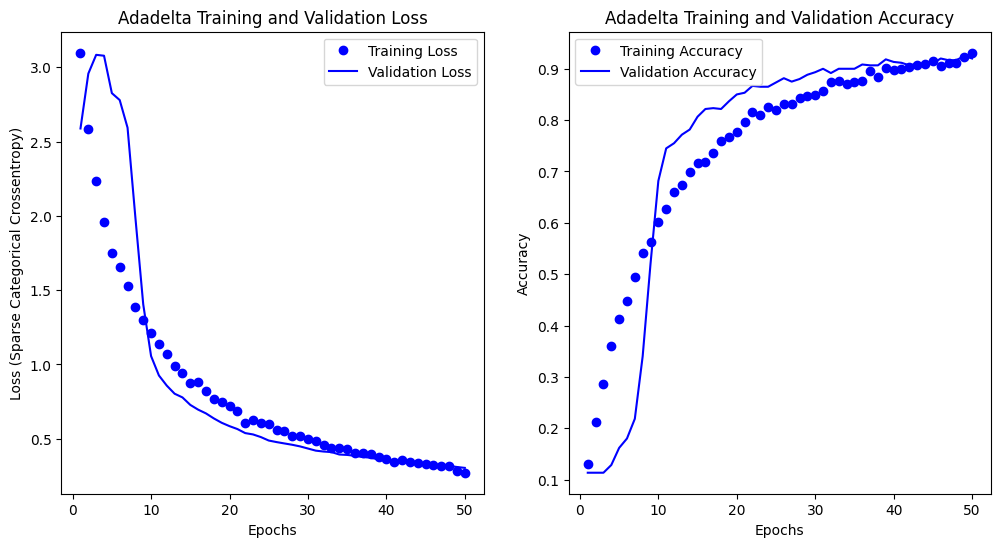

In [76]:
def show_performance(history, optPhrase, perfList):
    loss_str = optPhrase + ' Loss: {eval_loss}'
    accur_str = optPhrase + ' Accuracy: {eval_accur}'
    print(loss_str.format(eval_loss=perfList.at['Loss', optPhrase]))
    print(accur_str.format(eval_accur=perfList.at['Accuracy', optPhrase]))
    
    loss = history.history['loss']
    validation_loss = history.history['val_loss']
    accur = history.history['accuracy']
    validation_accur = history.history['val_accuracy']
    epochs = range(1, len(loss) + 1)
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, validation_loss, 'b', label='Validation Loss')
    plt.title(optPhrase + ' Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (Sparse Categorical Crossentropy)')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accur, 'bo', label='Training Accuracy')
    plt.plot(epochs, validation_accur, 'b', label='Validation Accuracy')
    plt.title(optPhrase + ' Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

show_performance(adad_history, 'Adadelta', perfList)

Adagrad Loss: 0.11
Adagrad Accuracy: 0.9667


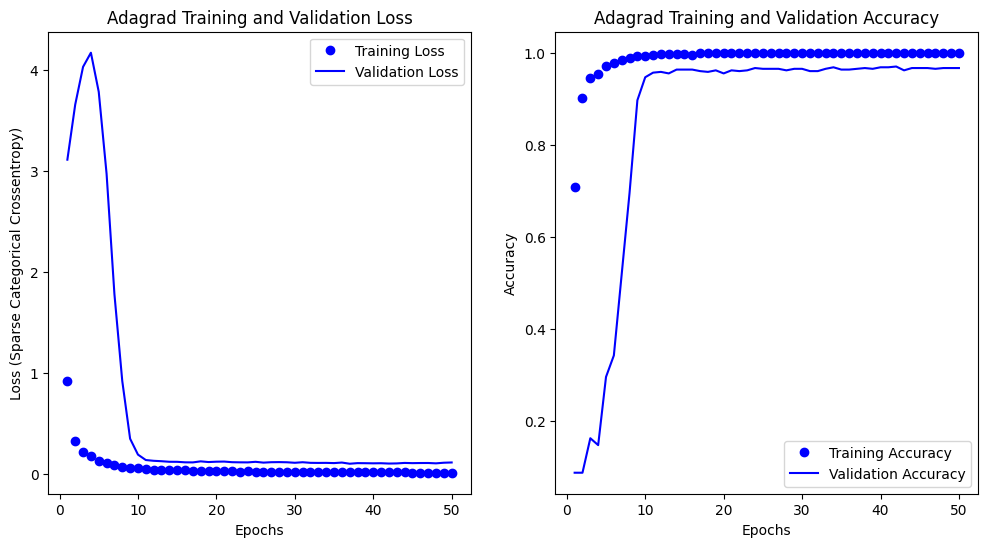

In [77]:
show_performance(adag_history, 'Adagrad', perfList)

Adam Loss: 0.0528
Adam Accuracy: 0.9833


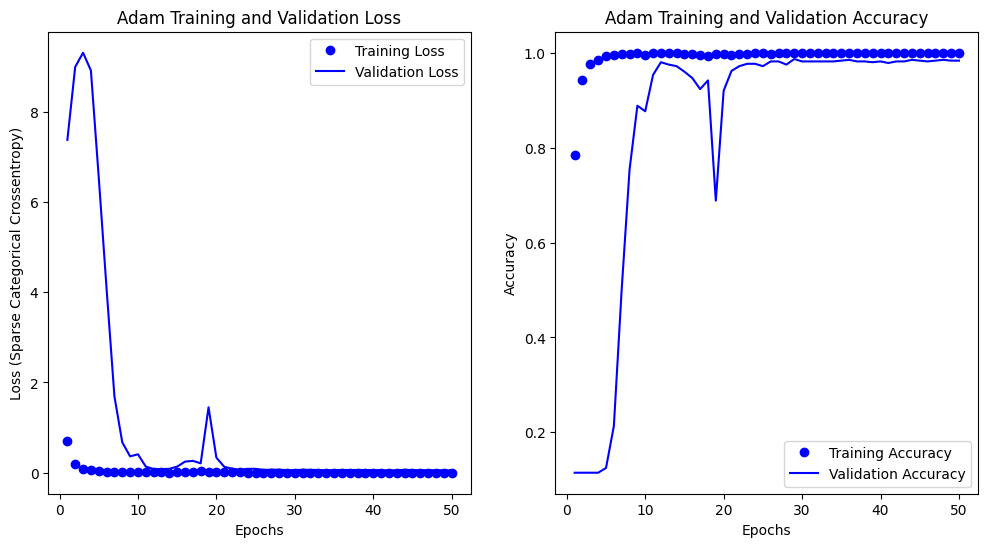

In [78]:
show_performance(adam_history, 'Adam', perfList)

Adamax Loss: 0.0861
Adamax Accuracy: 0.9717


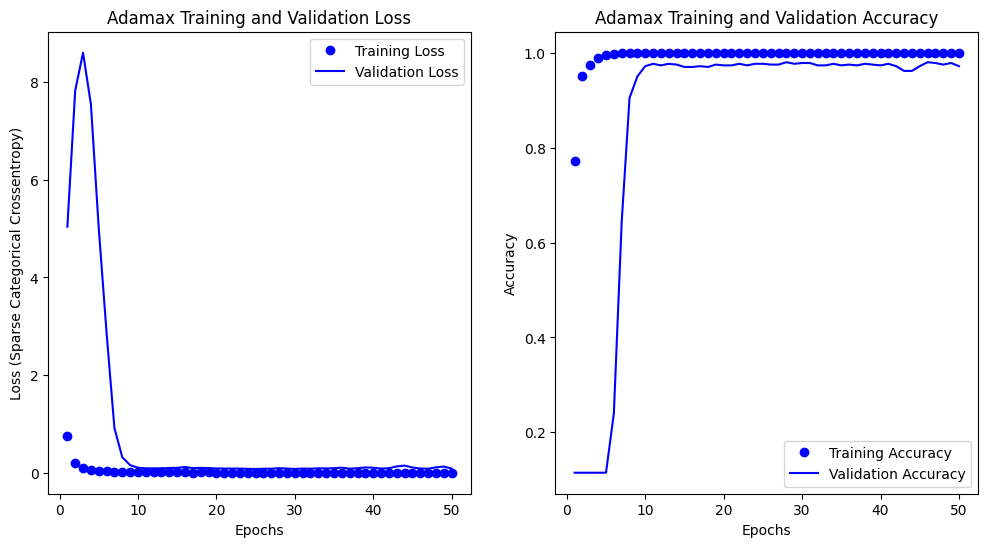

In [79]:
show_performance(adax_history, 'Adamax', perfList)

Ftrl Loss: 2.3031
Ftrl Accuracy: 0.0867


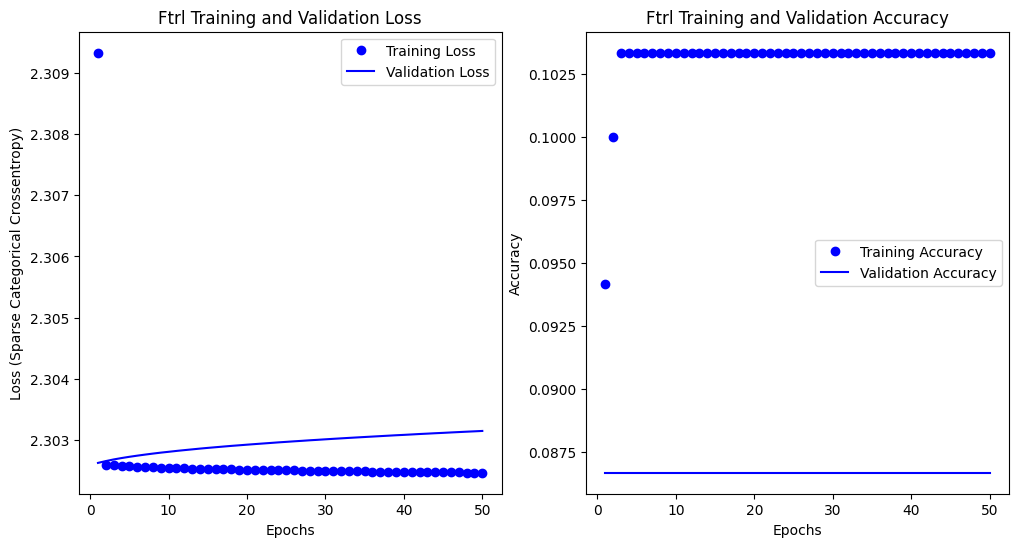

In [80]:
show_performance(ftrl_history, 'Ftrl', perfList)

Nadam Loss: 0.0529
Nadam Accuracy: 0.985


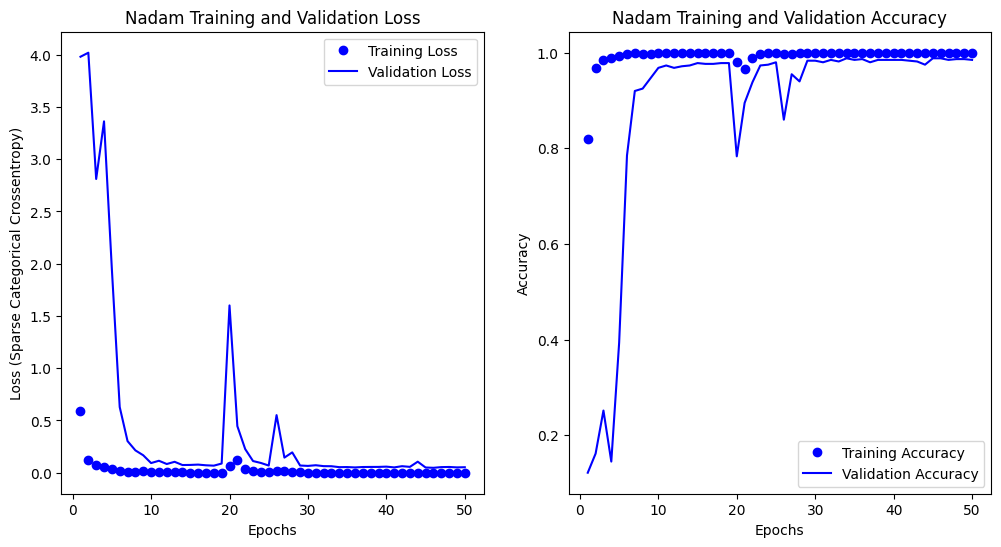

In [81]:
show_performance(nadam_history, 'Nadam', perfList)

RMSprop Loss: 0.281
RMSprop Accuracy: 0.9333


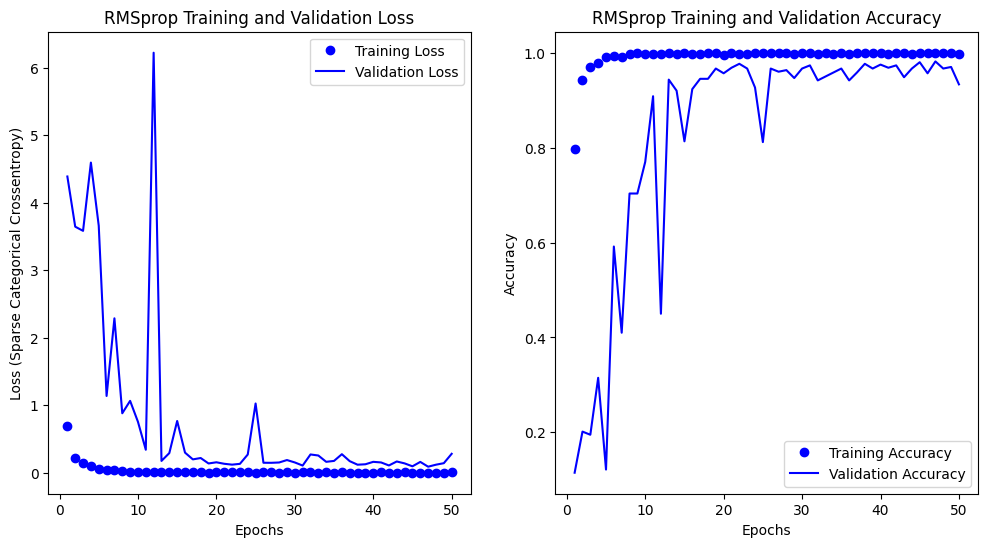

In [82]:
show_performance(rms_history, 'RMSprop', perfList)

SGD Loss: 0.0861
SGD Accuracy: 0.9717


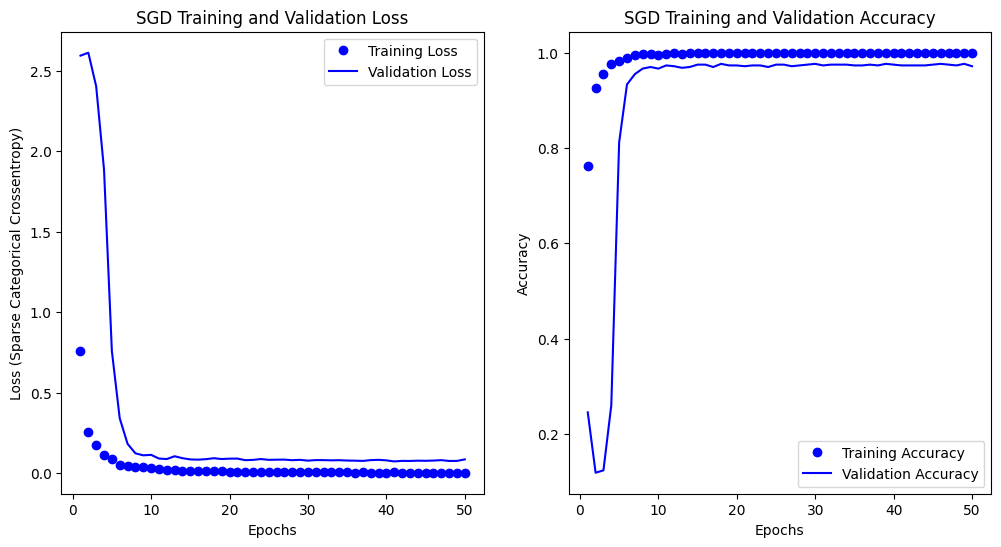

In [83]:
show_performance(sgd_history, 'SGD', perfList)

In [84]:
timeList

Adadelta    Adagrad       Adam     Adamax      Ftrl     Nadam  \
Train  3m 37.9s  3m 37.47s  3m 36.21s  3m 33.77s  3m 40.9s   4m 7.7s   
Test    0m 0.6s    0m 0.6s   0m 0.58s   0m 0.57s   0m 0.6s  0m 0.61s   

         RMSprop        SGD  
Train  3m 54.49s  3m 43.89s  
Test    0m 0.61s   0m 0.69s

In [85]:
perfList

Adadelta Adagrad    Adam  Adamax    Ftrl   Nadam RMSprop     SGD
Loss       0.3033    0.11  0.0528  0.0861  2.3031  0.0529   0.281  0.0861
Accuracy     0.92  0.9667  0.9833  0.9717  0.0867   0.985  0.9333  0.9717

In [86]:
shutil.rmtree(output_folder + 'audio-images')